# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; <b>for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement</b>.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Dataset overview
- The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.
- Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.
- As a simplification, there are no explicit products to track. Only the amounts of each transaction or offer are recorded.
- There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. Offers can be delivered via multiple channels.
- The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.


### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Import Packages

In [1]:
#import holy grail of data science
import pandas as pd
import numpy as np

#helper imports
from cleaner_help import transcript_cleaner

#more imports
import math
import json
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import Imputer , MinMaxScaler
from sklearn.decomposition import PCA
from tqdm import tqdm


#matplot magic
%matplotlib inline


# Load Data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1.0 Exploratory Data Analysis

## 1.1 portfolio

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
#get shape
portfolio.shape

(10, 6)

In [5]:
# data types
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [6]:
#quick stats
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
portfolio.corr()

,difficulty,duration,reward
difficulty,1.000000,0.808414,0.465686
duration,0.808414,1.000000,0.160262
reward,0.465686,0.160262,1.000000


In [8]:
#check for missing values if any
portfolio.isna().mean()

channels      0.0
difficulty    0.0
duration      0.0
id            0.0
offer_type    0.0
reward        0.0
dtype: float64

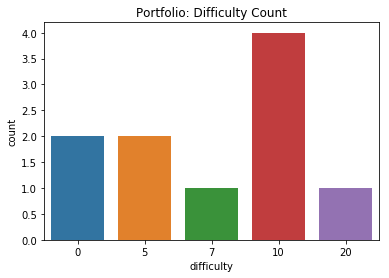

In [9]:
#se distribution of difficulty
sns.countplot(x='difficulty',data = portfolio)
plt.title("Portfolio: Difficulty Count")
plt.savefig("plots/portfolio_difficulty_count.png")
plt.show()

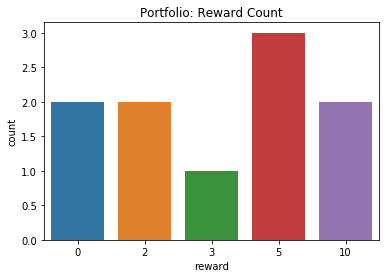

In [10]:
#see reward distribution
sns.countplot(x='reward', data = portfolio)
plt.title("Portfolio: Reward Count")
plt.savefig("plots/portfolio_reward_count.png")
plt.show()

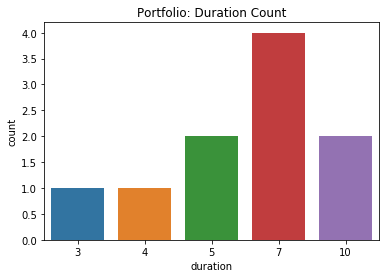

In [11]:
#see reward distribution
sns.countplot(x='duration', data = portfolio)
plt.title("Portfolio: Duration Count")
plt.savefig("plots/portfolio_duration_count.png")
plt.show()

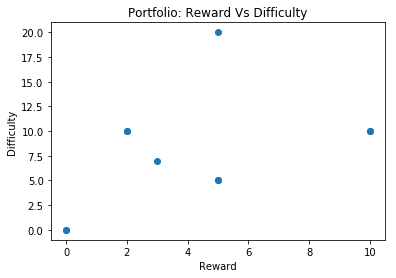

In [12]:
#plot reward vs difficulty
plt.scatter(portfolio['reward'], portfolio['difficulty'])
plt.xlabel("Reward")
plt.ylabel("Difficulty")
plt.title("Portfolio: Reward Vs Difficulty")
plt.savefig("plots/reward_vs_diff.png")
plt.show()

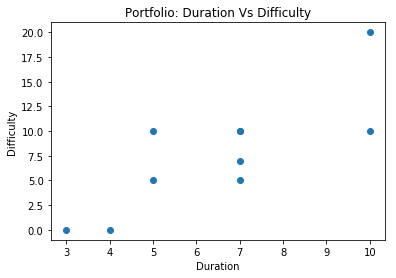

In [13]:
#plot duration vs difficulty
plt.scatter(portfolio['duration'], portfolio['difficulty'])
plt.xlabel("Duration")
plt.ylabel("Difficulty")
plt.title("Portfolio: Duration Vs Difficulty")
plt.savefig("plots/duration_vs_diff.png")
plt.show()

In [14]:
#get offer types
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

### Notes on portfolio

- create dummy columns for the channels
- create dummy columns for the offer type
- No missing values so no cleaning needed
- We can leave the offer ID as is or make a dict
- We can scale between 0 and 1: difficulty, reward, duration.


## 1.2 profile

In [15]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [16]:
#shape
profile.shape

(17000, 5)

In [17]:
#data types
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [18]:
#quick stats
profile[profile['age']!=118].describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [19]:
#quicker stats
profile[profile['age']!=118].corr(method='pearson')

,age,became_member_on,income
age,1.000000,-0.013425,0.306703
became_member_on,-0.013425,1.000000,-0.029009
income,0.306703,-0.029009,1.000000


In [20]:
#fraction of missing values
profile.isna().mean()

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

In [21]:
#see what fraction are of unknown age
profile[profile['age']==118].shape[0] / profile.shape[0]

0.12794117647058822

In [22]:
#count of missing values
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [23]:
#note that some users have unknown age, gender, income
profile[profile['age']==118].isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [24]:
#confirm that some users have no identifiable information
assert (profile[profile['age']==118].index == profile[profile['gender'].isna()].index).all
assert (profile[profile['age']==118].index == profile[profile['income'].isna()].index).all

In [25]:
#keep track of unknown users
profile_noinfo_idx = profile[profile['age']==118].index

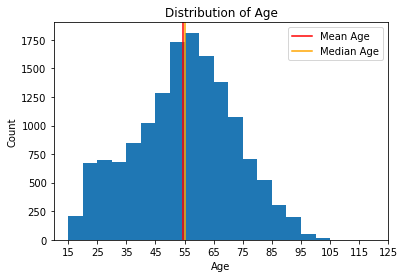

In [26]:
plt.hist(profile[profile['age']!=118]['age'], bins=np.arange(15, 120, 5))
plt.xticks(np.arange(15, 130, 10))
plt.axvline(profile[profile['age']!=118]['age'].mean(), color='red',label='Mean Age')
plt.axvline(profile[profile['age']!=118]['age'].median(), color='orange',label='Median Age')
plt.legend()
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Age")
plt.savefig("plots/profile_age_hist.png")
plt.show()

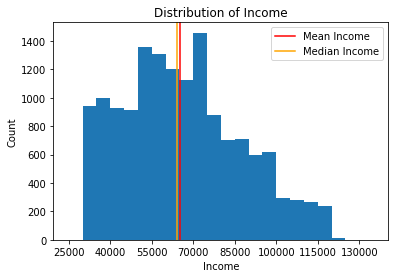

In [27]:
plt.hist(profile['income'].dropna(), bins=np.arange(25000, 140000, 5000))
plt.xticks(np.arange(25000, 140000, 15000))
plt.axvline(profile['income'].mean(), color='red',label='Mean Income')
plt.axvline(profile['income'].median(), color='orange',label='Median Income')
plt.legend()
plt.xlabel("Income")
plt.ylabel("Count")
plt.title("Distribution of Income")
plt.savefig("plots/profile_income_hist.png")
plt.show()

In [28]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

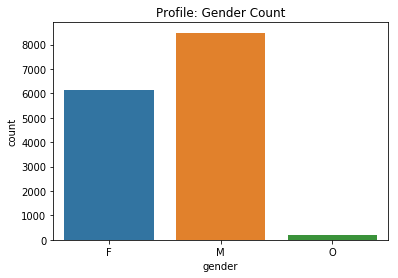

In [29]:
#see reward distribution
sns.countplot(x='gender', data = profile)
plt.title("Profile: Gender Count")
plt.savefig("plots/profile_gender_count.png")
plt.show()

### Notes on profile:
- age: missing value encoded as 118, neeed to keeep note of that
- date first joined needs to be transformed to datetime
- For some users we know nothing at all. We might not want to drop them if they don't buy at all

## 1.3 transcript

In [30]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [31]:
transcript.shape

(306534, 4)

In [32]:
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

In [33]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [34]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

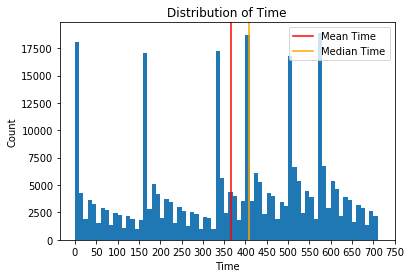

In [35]:
plt.hist(transcript['time'], bins=np.arange(0, 720,10))
plt.xticks(np.arange(0, 800,50))
plt.axvline(transcript['time'].mean(), color='red',label='Mean Time')
plt.axvline(transcript['time'].median(), color='orange',label='Median Time')
plt.legend(loc='upper right')
plt.xlabel("Time")
plt.ylabel("Count")
plt.title("Distribution of Time")
plt.savefig("plots/transcript_time_hist.png")
plt.show()

### Notes on transcript:
- the event should be replaced by integers for mapping
- the person can be replaced with an integer representation
- the value column is a dict type, need to explore that more
- The time of event can't be correlated with user sign up date
- will have to make an observation df

# 2.0 Cleaning the Dataset

## 2.1 portflolio

In [36]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [37]:
#get dummies for entries in channels
#note that it's a pandas series wth lists
channels_dum = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
channels_dum

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [38]:
offer_type_dum = pd.get_dummies(portfolio.offer_type)
offer_type_dum

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,1,0,0
9,0,1,0


In [39]:
#create dict to store offer id as int
offer_to_int = dict(zip(portfolio.sort_values(by='difficulty').id, np.arange(0, portfolio.shape[0])))

#create dict for reverse
int_to_offer = {value:key for key,value in offer_to_int.items()}

offer_to_int

{'3f207df678b143eea3cee63160fa8bed': 0,
 '5a8bc65990b245e5a138643cd4eb9837': 1,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 2,
 'f19421c1d4aa40978ebb69ca19b0e20d': 3,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 4,
 'ae264e3637204a6fb9bb56bc8210ddfd': 5,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '2906b810c7d4411798c6938adc9daaa5': 8,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 9}

In [40]:
#create deep copy
portfolio_clean = portfolio.copy()

#combine original data with dummy data
portfolio_clean = pd.concat([portfolio_clean, channels_dum, offer_type_dum], axis=1)


#replace the offers with the integer
portfolio_clean.id.replace(offer_to_int, inplace=True)

#drop the columns we don't need
portfolio_clean.drop(columns=['channels', 'offer_type'], inplace=True)


#normalize difficulty
#portfolio_clean['difficulty'] = portfolio_clean['difficulty']/portfolio_clean['difficulty'].max()

#make duration a day
portfolio_clean['duration'] = portfolio_clean['duration']*24.0

#normalize duration
#portfolio_clean['duration'] = portfolio_clean['duration']/portfolio_clean['duration'].max()

#normalize reward
#portfolio_clean['reward'] = portfolio_clean['reward']/portfolio_clean['reward'].max()

#order by id/difficulty
portfolio_clean = portfolio_clean.sort_values(by='difficulty')

portfolio_clean = portfolio_clean.reset_index(drop=True)

#save
portfolio_clean.to_csv("data/portfolio_clean.csv")

#see result
portfolio_clean

,difficulty,duration,id,reward,email,mobile,social,web,bogo,discount,informational
0,0,96.0,0,0,1,1,0,1,0,0,1
1,0,72.0,1,0,1,1,1,0,0,0,1
2,5,168.0,2,5,1,1,0,1,1,0,0
3,5,120.0,3,5,1,1,1,1,1,0,0
4,7,168.0,4,3,1,1,1,1,0,1,0
5,10,168.0,5,10,1,1,1,0,1,0,0
6,10,120.0,6,10,1,1,1,1,1,0,0
7,10,240.0,7,2,1,1,1,1,0,1,0
8,10,168.0,8,2,1,1,0,1,0,1,0
9,20,240.0,9,5,1,0,0,1,0,1,0


In [41]:
portfolio_clean.corr()

,difficulty,duration,id,reward,email,mobile,social,web,bogo,discount,informational
difficulty,1.000000,0.808414,0.921890,0.465686,NaN,-0.741058,-0.154957,0.244007,-0.029516,0.597692,-0.695872
duration,0.808414,1.000000,0.766733,0.160262,NaN,-0.529756,-0.185376,0.340557,-0.185376,0.741504,-0.681115
id,0.921890,0.766733,1.000000,0.337915,NaN,-0.522233,-0.071067,0.261116,-0.142134,0.710669,-0.696311
reward,0.465686,0.160262,0.337915,1.000000,NaN,-0.078431,0.288175,-0.117647,0.792482,-0.288175,-0.617647
email,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mobile,-0.741058,-0.529756,-0.522233,-0.078431,NaN,1.000000,0.408248,-0.166667,0.272166,-0.408248,0.166667
social,-0.154957,-0.185376,-0.071067,0.288175,NaN,0.408248,1.000000,-0.408248,0.250000,-0.166667,-0.102062
web,0.244007,0.340557,0.261116,-0.117647,NaN,-0.166667,-0.408248,1.000000,-0.102062,0.408248,-0.375000
bogo,-0.029516,-0.185376,-0.142134,0.792482,NaN,0.272166,0.250000,-0.102062,1.000000,-0.666667,-0.408248
discount,0.597692,0.741504,0.710669,-0.288175,NaN,-0.408248,-0.166667,0.408248,-0.666667,1.000000,-0.408248


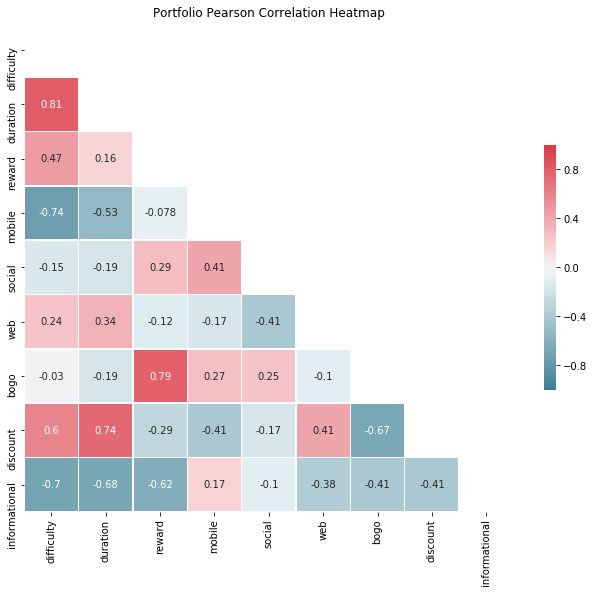

In [96]:
#get correlation matrix
protfolio_corr = portfolio_clean.corr()

#drop email because it has zero variance
#drop id because it should not be correlated to anything
protfolio_corr = protfolio_corr.drop(columns=['email', 'id'])
protfolio_corr = protfolio_corr.drop(index=['email', 'id'])


# Generate a mask for the upper triangle
mask = np.zeros_like(protfolio_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(protfolio_corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)


plt.title("Portfolio Pearson Correlation Heatmap")


plt.savefig("plots/portfolio_corr.png")

In the call above we can get away with normalizing with the max because we know that the metrics are always positive. In addition we will assume that the offers we see here are all the offers there are to see.

## 2.2 profile

In [43]:
profile_clean = profile.copy()

profile_clean.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [44]:
#convert join date to datetime object
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'],format="%Y%m%d")

In [45]:
#replace gender with integer mapping
profile_clean.gender.replace({'F': 0, 'M': 1, 'O':2, None: 2}, inplace=True)

In [46]:
#replace age 118 with integer mapping
profile_clean.age = profile_clean.age.replace(to_replace=118, value=np.nan)

In [47]:
#assert we have no duplicate users
assert profile_clean.shape[0] == profile_clean.id.nunique()

# make dict to map user id to an int
human_to_int= dict(zip(profile_clean.id, np.arange(0, profile_clean.shape[0])))

#make dict to map int to user id
int_to_human = {value:key for key,value in human_to_int.items()}

#replace string identifiers for id with dict
profile_clean.id.replace(human_to_int, inplace=True)

profile_clean['person'] = profile_clean.index

In [48]:
profile_clean.dtypes

age                        float64
became_member_on    datetime64[ns]
gender                       int64
id                           int64
income                     float64
person                       int64
dtype: object

In [49]:
profile_clean.head(10)

,age,became_member_on,gender,id,income,person
0,NaN,2017-02-12,2,0,NaN,0
1,55.0,2017-07-15,0,1,112000.0,1
2,NaN,2018-07-12,2,2,NaN,2
3,75.0,2017-05-09,0,3,100000.0,3
4,NaN,2017-08-04,2,4,NaN,4
5,68.0,2018-04-26,1,5,70000.0,5
6,NaN,2017-09-25,2,6,NaN,6
7,NaN,2017-10-02,2,7,NaN,7
8,65.0,2018-02-09,1,8,53000.0,8
9,NaN,2016-11-22,2,9,NaN,9


## 2.3 Transcript

### Pre-Cleaning Steps

In [50]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [51]:
transcript.tail()

,event,person,time,value
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [52]:
#see unique values in events
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [53]:
#make dummies for event column
event_dummies = pd.get_dummies(transcript['event'])
event_dummies.head()

,offer completed,offer received,offer viewed,transaction
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [54]:
#separate the value dicts with the keys as the columns
value_df = transcript['value'].apply(pd.Series)
value_df.head(5)

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [55]:
#see tail
value_df.tail()

,offer id,amount,offer_id,reward
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN
306533,NaN,4.05,NaN,NaN


In [56]:
#distribution of missing values
value_df.isna().mean()

offer id    0.562848
amount      0.546696
offer_id    0.890456
reward      0.890456
dtype: float64

In [57]:
#see if both are mutually exclusive per observation
value_df[(~value_df['offer id'].isna()) & (~value_df['offer_id'].isna())]

,offer id,amount,offer_id,reward


In [58]:
#store all possible keys in values
value_all_keys = []
#loop over entries
for k in transcript['value']:
    new_key = list(k.keys())
    value_all_keys.extend(new_key)

#print all possible keys
print(set(value_all_keys))

{'offer_id', 'amount', 'reward', 'offer id'}


In [59]:
#print unique offer id
#nan means no offer made
print(value_df['offer id'].unique())
print(len(value_df['offer id'].unique()))

['9b98b8c7a33c4b65b9aebfe6a799e6d9' '0b1e1539f2cc45b7b9fa7c272da2e1d7'
 '2906b810c7d4411798c6938adc9daaa5' 'fafdcd668e3743c1bb461111dcafc2a4'
 '4d5c57ea9a6940dd891ad53e9dbe8da0' 'f19421c1d4aa40978ebb69ca19b0e20d'
 '2298d6c36e964ae4a3e7e9706d1fb8c2' '3f207df678b143eea3cee63160fa8bed'
 'ae264e3637204a6fb9bb56bc8210ddfd' '5a8bc65990b245e5a138643cd4eb9837' nan]
11


In [60]:
print(value_df['offer_id'].unique())
print(len(value_df['offer_id'].unique()))

[nan '2906b810c7d4411798c6938adc9daaa5' 'fafdcd668e3743c1bb461111dcafc2a4'
 '9b98b8c7a33c4b65b9aebfe6a799e6d9' 'ae264e3637204a6fb9bb56bc8210ddfd'
 '4d5c57ea9a6940dd891ad53e9dbe8da0' '2298d6c36e964ae4a3e7e9706d1fb8c2'
 'f19421c1d4aa40978ebb69ca19b0e20d' '0b1e1539f2cc45b7b9fa7c272da2e1d7']
9


#### !Note!
After some investigation, we shall assume that the 'offer_id' and 'offer id' entries are the same. The difference is simply a typo. We shall treat them as the same.

In [61]:
#combine the two columns
value_df['offer_id'] = value_df['offer id'].combine_first(value_df['offer_id'])
#drop the old column
value_df = value_df.drop(columns=['offer id'])

In [62]:
#concatenate new columns
transcript_comb = pd.concat([transcript, event_dummies, value_df], axis = 1)
transcript_comb.head()

,event,person,time,value,offer completed,offer received,offer viewed,transaction,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


Here we want to replace the person with an integer and the offer_id with its corresponding integer.

This [post](https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict) shows that using panda's map method might actually be faster.

In [63]:
#map humans to integers
transcript_comb['person'] = transcript_comb['person'].map(human_to_int)

#map offer_id to integer
transcript_comb['offer_id'] = transcript_comb['offer_id'].map(offer_to_int)

#drop columns
transcript_comb = transcript_comb.drop(columns=['event', 'value'])

#rearrange columns

transcript_comb=transcript_comb[['person', 'time', 'offer_id',
                                 'offer received', 'offer viewed', 'offer completed',
                                 'transaction', 'amount', 'reward']]


#save as csv
transcript_comb.to_csv('data/transcript_comb.csv')

#display
transcript_comb.head()

,person,time,offer_id,offer received,offer viewed,offer completed,transaction,amount,reward
0,3,0,2.0,1,0,0,0,NaN,NaN
1,4,0,9.0,1,0,0,0,NaN,NaN
2,5,0,8.0,1,0,0,0,NaN,NaN
3,6,0,7.0,1,0,0,0,NaN,NaN
4,7,0,6.0,1,0,0,0,NaN,NaN


In [64]:
#see observation for person 35
person_35 = transcript_comb[transcript_comb['person']==35]
person_35.to_excel("data/person_35.xlsx")
(person_35)

,person,time,offer_id,offer received,offer viewed,offer completed,transaction,amount,reward
22,35,0,6.0,1,0,0,0,NaN,NaN
12652,35,0,6.0,0,1,0,0,NaN,NaN
15563,35,6,NaN,0,0,0,1,19.88,NaN
15564,35,6,6.0,0,0,1,0,NaN,10.0
18070,35,12,NaN,0,0,0,1,14.35,NaN
27847,35,42,NaN,0,0,0,1,8.05,NaN
36916,35,78,NaN,0,0,0,1,12.79,NaN
53198,35,168,0.0,1,0,0,0,NaN,NaN
72151,35,180,0.0,0,1,0,0,NaN,NaN
77218,35,192,NaN,0,0,0,1,8.21,NaN


In [65]:
#see observation for person 2
person_2 = transcript_comb[transcript_comb['person']==2]
person_2.to_excel("data/person_2.xlsx")
person_2

,person,time,offer_id,offer received,offer viewed,offer completed,transaction,amount,reward
47581,2,132,NaN,0,0,0,1,1.34,NaN
53175,2,168,2.0,1,0,0,0,NaN,NaN
65843,2,168,2.0,0,1,0,0,NaN,NaN
130148,2,348,NaN,0,0,0,1,1.64,NaN
184911,2,450,NaN,0,0,0,1,3.47,NaN
193184,2,474,NaN,0,0,0,1,1.62,NaN
245123,2,576,1.0,1,0,0,0,NaN,NaN
285920,2,636,NaN,0,0,0,1,2.14,NaN
294714,2,666,1.0,0,1,0,0,NaN,NaN
301916,2,696,NaN,0,0,0,1,4.09,NaN


In [66]:
#sample for user 0
person_0 = transcript_comb[transcript_comb['person']==0]
person_0.to_excel("data/person_0.xlsx")
person_0

,person,time,offer_id,offer received,offer viewed,offer completed,transaction,amount,reward
53174,0,168,8.0,1,0,0,0,NaN,NaN
85290,0,216,8.0,0,1,0,0,NaN,NaN
110828,0,336,9.0,1,0,0,0,NaN,NaN
130147,0,348,9.0,0,1,0,0,NaN,NaN
135224,0,360,NaN,0,0,0,1,0.35,NaN
150596,0,408,7.0,1,0,0,0,NaN,NaN
163374,0,408,7.0,0,1,0,0,NaN,NaN
167626,0,414,NaN,0,0,0,1,0.74,NaN
182544,0,444,NaN,0,0,0,1,1.89,NaN
201570,0,504,4.0,1,0,0,0,NaN,NaN


In [67]:
#display  history of person 0  with offer 6
transcript_comb[(transcript_comb['person']==0) & (transcript_comb['offer_id']==6)]

,person,time,offer_id,offer received,offer viewed,offer completed,transaction,amount,reward


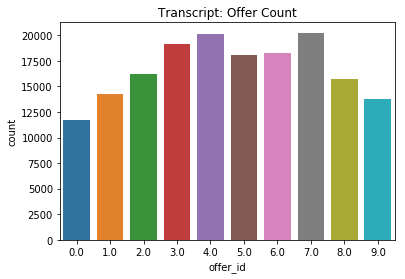

In [68]:
#see offer distribution
sns.countplot(x='offer_id', data = transcript_comb)
plt.title("Transcript: Offer Count")
plt.savefig("plots/transcript_offer_id_count.png")
plt.show()

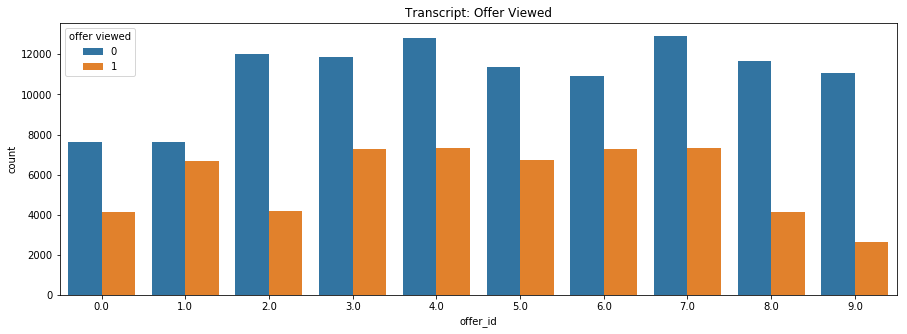

In [69]:
#see offers viewed distribution
plt.figure(figsize= (15,5))
sns.countplot(x='offer_id', hue='offer viewed',data = transcript_comb)
plt.title("Transcript: Offer Viewed")
plt.savefig("plots/transcript_offer_viewed_count.png")
plt.show()

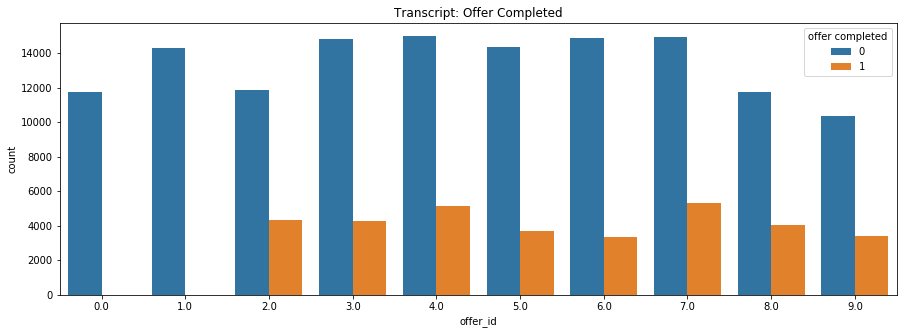

In [70]:
#see offers completed distribution
plt.figure(figsize= (15,5))
sns.countplot(x='offer_id', hue='offer completed',data = transcript_comb)
plt.title("Transcript: Offer Completed")
plt.savefig("plots/transcript_offer_completed_count.png")
plt.show()

### Summation Log

In this section we take the summation of features grouped by user regardless of the spending type and the behavior.

In [71]:
#get a summation of spending
transcript_comb_sigma = transcript_comb.groupby(by='person', as_index=False).sum()
transcript_comb_sigma = transcript_comb_sigma[['person', 'amount',
                                               'transaction','offer received',
                                               'offer viewed','offer completed']]
#rename columns accordingly
transcript_comb_sigma = transcript_comb_sigma.rename(columns={'amount': 'total_amount',
                                                              'transaction': 'total_transaction',
                                                              'offer received': 'total_offer_received',
                                                              'offer viewed': 'total_offer_viewed',
                                                              'offer completed': 'total_offer_completed'})

transcript_comb_sigma.head()

,person,total_amount,total_transaction,total_offer_received,total_offer_viewed,total_offer_completed
0,0,20.40,9,5,5,2
1,1,77.01,3,2,0,1
2,2,14.30,6,2,2,0
3,3,159.27,7,4,4,3
4,4,4.65,3,5,3,0


### Observations Before Cleaning

We will make a dataframe of the observations and then generalize it to the users. We can see from the above examples that:
- The clock starts ticking one a user receives an offer
- The clock does not always start at 0
- The clock does not reset if another offer is received
- The clock does not reset if the offer is completed
- Different users are observed over different timeframes
- If the spending is done within the influence window then the amount spent is given the offer id
- The user is under the influence of the first offer viewed until it is completed if applicable
- There are users who have not received any offer whatsoever and still spent money

### Cleaning Transcript

In [72]:
#dict to map offer to time
offer_to_time = dict(zip(portfolio_clean['id'], portfolio_clean['duration']))
offer_to_time

{0: 96.0,
 1: 72.0,
 2: 168.0,
 3: 120.0,
 4: 168.0,
 5: 168.0,
 6: 120.0,
 7: 240.0,
 8: 168.0,
 9: 240.0}

In [73]:
#run this cell to fill in offers

### warining this takes some time ###
transcript_full, transcript_time = transcript_cleaner(transcript, offer_to_int, offer_to_time, human_to_int)

In [74]:
transcript_full.head()

,person,offer_id,time,offer received,offer viewed,offer completed,transaction,reward,amount
0,3,2.0,0,1,0,0,0,NaN,NaN
15561,3,2.0,6,0,1,0,0,NaN,NaN
47582,3,2.0,132,0,0,0,1,NaN,19.89
47583,3,2.0,132,0,0,1,0,5.0,NaN
49502,3,NaN,144,0,0,0,1,NaN,17.78


In [75]:
transcript_time.head()

,person,offer_id,time_to_open,time_to_complete
0,3,2.0,0.035714,0.785714
1,3,1.0,0.666667,NaN
2,3,5.0,0.000000,NaN
0,4,9.0,0.025000,NaN
1,4,0.0,0.000000,NaN


In [76]:
#create an observation log
transcript_log = transcript_full.groupby(['person','offer_id']).sum(index=0).reset_index()
#drop the time column
transcript_log = transcript_log.drop(columns=['time'])

#save as csv
transcript_log.to_csv("data/transcript_log.csv")

transcript_log.head(10)

,person,offer_id,offer received,offer viewed,offer completed,transaction,reward,amount
0,0,4.0,1,1,1,3,3.0,7.54
1,0,7.0,2,2,1,2,2.0,2.63
2,0,8.0,1,1,0,0,0.0,0.00
3,0,9.0,1,1,0,1,0.0,0.35
4,1,0.0,1,0,0,0,0.0,0.00
5,1,2.0,1,0,1,0,5.0,0.00
6,2,1.0,1,1,0,0,0.0,0.00
7,2,2.0,1,1,0,0,0.0,0.00
8,3,1.0,1,1,0,2,0.0,49.39
9,3,2.0,1,1,1,1,5.0,19.89


In [77]:
#combine offer with corresponding attributes
full_transcript = pd.merge(left=transcript_log,
                           right = portfolio_clean.drop(columns=['duration', 'reward']),
                           how='left', left_on='offer_id', right_on='id')

#drop redundant information
full_transcript = full_transcript.drop(columns=['id'])

#multiply email/mobile/social/web by the number of offers received
full_transcript[['email', 'mobile', 'social', 'web']] = \
full_transcript[['email', 'mobile', 'social', 'web']].multiply(full_transcript['offer received'], axis=0)


#save to csv
full_transcript.to_csv('data/full_transcript.csv')

full_transcript.head(10)

,person,offer_id,offer received,offer viewed,offer completed,transaction,reward,amount,difficulty,email,mobile,social,web,bogo,discount,informational
0,0,4.0,1,1,1,3,3.0,7.54,7,1,1,1,1,0,1,0
1,0,7.0,2,2,1,2,2.0,2.63,10,2,2,2,2,0,1,0
2,0,8.0,1,1,0,0,0.0,0.00,10,1,1,0,1,0,1,0
3,0,9.0,1,1,0,1,0.0,0.35,20,1,0,0,1,0,1,0
4,1,0.0,1,0,0,0,0.0,0.00,0,1,1,0,1,0,0,1
5,1,2.0,1,0,1,0,5.0,0.00,5,1,1,0,1,1,0,0
6,2,1.0,1,1,0,0,0.0,0.00,0,1,1,1,0,0,0,1
7,2,2.0,1,1,0,0,0.0,0.00,5,1,1,0,1,1,0,0
8,3,1.0,1,1,0,2,0.0,49.39,0,1,1,1,0,0,0,1
9,3,2.0,1,1,1,1,5.0,19.89,5,1,1,0,1,1,0,0


In [78]:
#make a groupby object around users
full_transcript_groupby = full_transcript.groupby(by='person', as_index=False)

In [79]:
#get sums 
full_transcript_sum = full_transcript_groupby.sum()

#drop uneeded columns
full_transcript_sum = full_transcript_sum.drop(columns=['offer_id', 'difficulty'])

#rename columns
full_transcript_sum = full_transcript_sum.rename(columns={'amount': 'amount_infl',
                                                          'reward': 'reward_infl'})

full_transcript_sum.head()

,person,offer received,offer viewed,offer completed,transaction,reward_infl,amount_infl,email,mobile,social,web,bogo,discount,informational
0,0,5,5,2,6,5.0,10.52,5,4,3,5,0,4,0
1,1,2,0,1,0,5.0,0.00,2,2,0,2,1,0,1
2,2,2,2,0,0,0.0,0.00,2,2,1,1,1,0,1
3,3,4,4,3,3,20.0,69.28,4,4,3,2,3,0,1
4,4,5,3,0,1,0.0,1.09,5,2,1,4,0,1,2


In [80]:
#get means
full_transcript_mean = full_transcript_groupby.mean()

#get relevant columns
full_transcript_mean = full_transcript_mean[['person', 'difficulty']]

#rename
full_transcript_mean = full_transcript_mean.rename(columns={'difficulty': 'avg_difficulty'})

full_transcript_mean.head()

,person,avg_difficulty
0,0,11.750000
1,1,2.500000
2,2,2.500000
3,3,5.000000
4,4,6.666667


In [81]:
transcript_time.head()

,person,offer_id,time_to_open,time_to_complete
0,3,2.0,0.035714,0.785714
1,3,1.0,0.666667,NaN
2,3,5.0,0.000000,NaN
0,4,9.0,0.025000,NaN
1,4,0.0,0.000000,NaN


In [82]:
#get a time based log with averages
time_log = transcript_time.groupby(by='person', as_index=False).mean()

#drop uneeded columns
time_log = time_log.drop(columns=['offer_id'])

time_log.head()

,person,time_to_open,time_to_complete
0,0,0.083929,0.285714
1,1,NaN,NaN
2,2,0.000000,NaN
3,3,0.234127,0.785714
4,4,0.012500,NaN


### User Dataframe

Create a dataframe where we have statistics about each user

In [83]:
#merge on means and sums
transctipt_sum_mean = pd.merge(left=full_transcript_sum, right=full_transcript_mean, how='inner', on='person')

#merge on times
user_df = pd.merge(transctipt_sum_mean, time_log, how='inner', on='person')

#merge on totals
user_df = pd.merge(user_df, transcript_comb_sigma[['person', 'total_amount']], how='inner', on='person')

#get percentage spent due to offers
user_df['amount_pct'] = user_df['amount_infl'] / user_df['total_amount']

#add user information
user_df = pd.merge(user_df, profile_clean.drop(columns=['id', 'became_member_on']), how='inner', on='person')


#round difficulty to nearest int
user_df['avg_difficulty'] = user_df['avg_difficulty'].round()

#fill up nan values in time_to_open and time_to_complete with 1
user_df['time_to_open'] = user_df['time_to_open'].fillna(value=1)
user_df['time_to_complete'] = user_df['time_to_complete'].fillna(value=1)

#get a measure of responsivitiy 
user_df['seen_ratio'] = user_df['offer viewed'] / user_df['offer received']

#get a measure of willingness to complete
user_df['completed_ratio'] = user_df['offer completed'] / user_df['offer received']

#in case of inifinty i.e. 0 received, replace with 0

user_df['completed_ratio'] = user_df['completed_ratio'].replace(to_replace=np.inf, value=0)

user_df.head()

,person,offer received,offer viewed,offer completed,transaction,reward_infl,amount_infl,email,mobile,social,...,avg_difficulty,time_to_open,time_to_complete,total_amount,amount_pct,age,gender,income,seen_ratio,completed_ratio
0,0,5,5,2,6,5.0,10.52,5,4,3,...,12.0,0.083929,0.285714,20.40,0.515686,NaN,2,NaN,1.0,0.40
1,1,2,0,1,0,5.0,0.00,2,2,0,...,2.0,1.000000,1.000000,77.01,0.000000,55.0,0,112000.0,0.0,0.50
2,2,2,2,0,0,0.0,0.00,2,2,1,...,2.0,0.000000,1.000000,14.30,0.000000,NaN,2,NaN,1.0,0.00
3,3,4,4,3,3,20.0,69.28,4,4,3,...,5.0,0.234127,0.785714,159.27,0.434985,75.0,0,100000.0,1.0,0.75
4,4,5,3,0,1,0.0,1.09,5,2,1,...,7.0,0.012500,1.000000,4.65,0.234409,NaN,2,NaN,0.6,0.00


In [84]:
user_df.columns

Index(['person', 'offer received', 'offer viewed', 'offer completed',
       'transaction', 'reward_infl', 'amount_infl', 'email', 'mobile',
       'social', 'web', 'bogo', 'discount', 'informational', 'avg_difficulty',
       'time_to_open', 'time_to_complete', 'total_amount', 'amount_pct', 'age',
       'gender', 'income', 'seen_ratio', 'completed_ratio'],
      dtype='object')

In [85]:
user_df.shape

(16921, 24)

In [86]:
#save as csv
user_df.to_csv("data/user_df.csv")

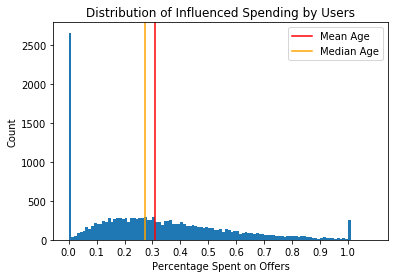

In [87]:
plt.hist(user_df['amount_pct'].dropna(), bins=np.arange(0, 1.1, 0.01))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.axvline(user_df['amount_pct'].dropna().mean(), color='red',label='Mean Age')
plt.axvline(user_df['amount_pct'].dropna().median(), color='orange',label='Median Age')
plt.legend()
plt.xlabel("Percentage Spent on Offers")
plt.ylabel("Count")
plt.title("Distribution of Influenced Spending by Users")
plt.savefig("plots/user_df_pct_ampunt.png")
plt.show()

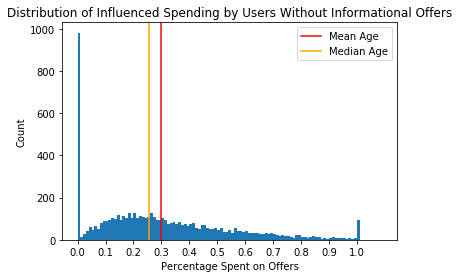

In [88]:
user_df_no_informational = user_df[user_df['informational']==0]

plt.hist(user_df_no_informational['amount_pct'].dropna(), bins=np.arange(0, 1.1, 0.01))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.axvline(user_df_no_informational['amount_pct'].dropna().mean(), color='red',label='Mean Age')
plt.axvline(user_df_no_informational['amount_pct'].dropna().median(), color='orange',label='Median Age')
plt.legend()
plt.xlabel("Percentage Spent on Offers")
plt.ylabel("Count")
plt.title("Distribution of Influenced Spending by Users Without Informational Offers")
plt.savefig("plots/user_df_pct_no_inform_ampunt.png")
plt.show()

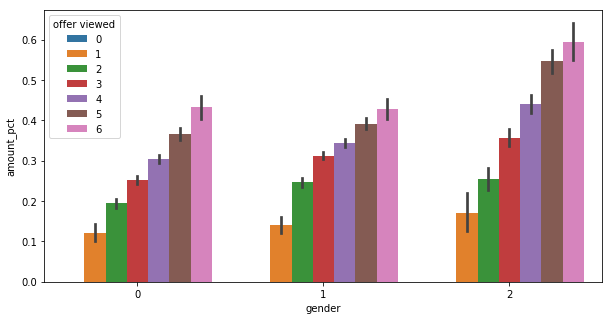

In [89]:
plt.figure(figsize=(10,5))
sns.barplot(x='gender', y='amount_pct', hue='offer viewed',data=user_df)
plt.savefig("plots/gender_amount_viewed.png")
plt.show()

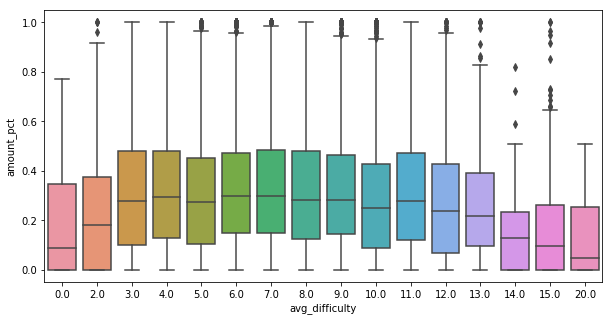

In [90]:
plt.figure(figsize=(10,5))
sns.boxplot(x='avg_difficulty', y='amount_pct',data=user_df)
plt.savefig("plots/boxplot_difficulty_amount.png")
plt.show()

In [91]:
user_df.isna().mean()

person              0.000000
offer received      0.000000
offer viewed        0.000000
offer completed     0.000000
transaction         0.000000
reward_infl         0.000000
amount_infl         0.000000
email               0.000000
mobile              0.000000
social              0.000000
web                 0.000000
bogo                0.000000
discount            0.000000
informational       0.000000
avg_difficulty      0.000000
time_to_open        0.000000
time_to_complete    0.000000
total_amount        0.000000
amount_pct          0.024526
age                 0.127829
gender              0.000000
income              0.127829
seen_ratio          0.000000
completed_ratio     0.000000
dtype: float64

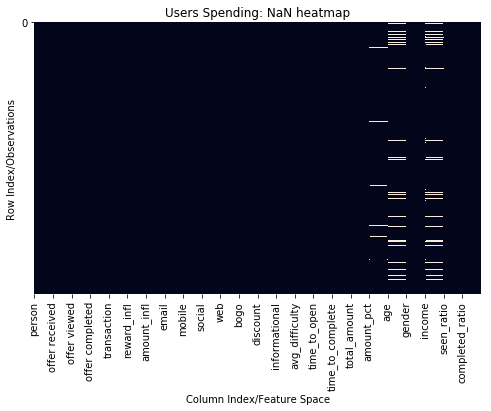

In [92]:
#get missing heatmap

plt.figure(figsize=(8,5))
sns.heatmap(user_df.isnull(), cbar=False)
plt.title("Users Spending: NaN heatmap")
plt.xticks(np.arange(0, user_df.shape[1], 1))
plt.yticks(np.arange(0, user_df.shape[0], 100000))
plt.xlabel("Column Index/Feature Space")
plt.ylabel("Row Index/Observations")
plt.savefig("plots/nan_heat.png")

plt.show()

For unkonwn values such as income, gender, and age, we will fill with the median value.

In [93]:
#instantiate imputer
imputer = Imputer(missing_values=np.NaN, strategy='median', axis=0)
#fit to the dataset
imputer.fit(user_df)

#transform the dataset by filling NaN values
user_df_median= imputer.transform(user_df)


#revert back to dataframe
user_df_median = pd.DataFrame(data = user_df_median, columns=user_df.columns)

#save as csv file
user_df_median.to_csv("data/user_df_median.csv")

user_df_median.head()

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,person,offer received,offer viewed,offer completed,transaction,reward_infl,amount_infl,email,mobile,social,...,avg_difficulty,time_to_open,time_to_complete,total_amount,amount_pct,age,gender,income,seen_ratio,completed_ratio
0,0.0,5.0,5.0,2.0,6.0,5.0,10.52,5.0,4.0,3.0,...,12.0,0.083929,0.285714,20.40,0.515686,55.0,2.0,64000.0,1.0,0.40
1,1.0,2.0,0.0,1.0,0.0,5.0,0.00,2.0,2.0,0.0,...,2.0,1.000000,1.000000,77.01,0.000000,55.0,0.0,112000.0,0.0,0.50
2,2.0,2.0,2.0,0.0,0.0,0.0,0.00,2.0,2.0,1.0,...,2.0,0.000000,1.000000,14.30,0.000000,55.0,2.0,64000.0,1.0,0.00
3,3.0,4.0,4.0,3.0,3.0,20.0,69.28,4.0,4.0,3.0,...,5.0,0.234127,0.785714,159.27,0.434985,75.0,0.0,100000.0,1.0,0.75
4,4.0,5.0,3.0,0.0,1.0,0.0,1.09,5.0,2.0,1.0,...,7.0,0.012500,1.000000,4.65,0.234409,55.0,2.0,64000.0,0.6,0.00


In [94]:
# Apply feature scaling 
scaler=MinMaxScaler()
#fit scaler
scaler.fit(user_df_median)
#transformed scaled data
user_scaled=scaler.transform(user_df_median)

In [95]:
# Apply feature scaling 
scaler=MinMaxScaler()
#fit scaler
scaler.fit(user_df_median)
#transformed scaled data
user_scaled=scaler.transform(user_df_median)

#rever to dataframe
user_scaled = pd.DataFrame(user_scaled, columns=user_df_median.columns)

#save as csv
user_scaled.to_csv("data/user_scaled.csv")